In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from adjustText import adjust_text
from pdb import set_trace as st 
import random
import json
import os 
from tqdm import tqdm
import string
from src.Aux import * 
from src.Triangles import Triangle
from src.Illustrate import * 

In [2]:
emnist_loc = "/home/yfrid/Desktop/stem-whiteboard/dataset/mnist/EMNIST/raw/"
emnist_images = read_idx_ubyte(emnist_loc+"emnist-byclass-train-images-idx3-ubyte")
emnist_labels = read_idx_ubyte(emnist_loc+"emnist-byclass-train-labels-idx1-ubyte")
emnist_chars = string.digits+string.ascii_uppercase+string.ascii_lowercase
EMNIST = EMNIST_Handler(emnist_images,emnist_labels,emnist_chars)

Reading image data: 697932 images of 28x28 pixels.
Reading label data: 697932 labels.


In [3]:
lower_letters = string.ascii_lowercase
#greek_letters = ['α', 'β', 'γ', 'δ', 'θ']

def plot_geometry_improved(description):
    labels = []
    handwritten = False#bool(random.getrandbits(1))
    # Set up the plot with some padding
    all_x = [v["x"] for v in description["vertices"]]
    all_y = [v["y"] for v in description["vertices"]]
    x_range = max(all_x) - min(all_x)
    y_range = max(all_y) - min(all_y)
    padding = max(x_range, y_range) * 0.1
    
    ax.set_xlim(min(all_x) - padding, max(all_x) + padding)
    ax.set_ylim(min(all_y) - padding, max(all_y) + padding)
    

#################################################### VERTICES    
    labels = plot_vertices(description,ax,EMNIST,handwritten)
####################################################### SEGMENTS
    description["index_lookup"] = {d["mark"]: i for i, d in enumerate(description["vertices"])} ## add index to each vertice for easier search
    description,segment_labels = plot_segments(description,ax,EMNIST,handwritten)

################################################### ANGLES
    description, angle_labels = plot_angles(description,ax,EMNIST,handwritten)
    
    # Combine all labels for adjustment
    all_labels = labels + segment_labels + angle_labels
    
    # Get all non-text artists (points, lines) to avoid
    avoid_objects = [artist for artist in ax.get_children() 
                    if not isinstance(artist, plt.Text)]
    
    # Fine-tune the label positioning
    adjust_text(all_labels, ax=ax,
                add_objects=avoid_objects,
                expand_points=(1.5, 1.5),    # Distance from points
                expand_text=(1.2, 1.2),     # Distance between labels
                expand_objects=(1.2, 1.2),  # Distance from lines/objects
                arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5, lw=0.5),
                force_points=(0.5, 0.5),    # Force to avoid points
                force_text=(0.5, 0.5),      # Force to avoid text overlap
                force_objects=(0.3, 0.3),   # Force to avoid other objects
                lim=1000)                   # Maximum iterations
    
    ax.set_aspect('equal')
    ax.axis('off')
#    ax.set_title('Geometry Problem', 
 #fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return description


def convert_numpy_types(obj):
    if isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_numpy_types(v) for v in obj]
    else:
        return obj



{'vertices': [{'mark': 'A', 'x': 0, 'y': 0},
  {'mark': 'B', 'x': 7, 'y': 0},
  {'mark': 'C', 'x': 0, 'y': 10},
  {'mark': 'D', 'x': 3.5, 'y': 0.0},
  {'mark': 'E', 'x': 3.5, 'y': 4.999999999999998},
  {'mark': 'F', 'x': 0.0, 'y': 3.6445889310135926}],
 'segments': [{'mark': 'AB', 'known': True, 'length': 7.0, 'unit': ['cm']},
  {'mark': 'AC', 'known': True, 'length': 'v', 'unit': ['cm']},
  {'mark': 'BC', 'known': True, 'length': 'n', 'unit': ['cm']},
  {'mark': 'AD', 'known': False},
  {'mark': 'DE', 'known': True, 'length': 5.0, 'unit': ['cm']},
  {'mark': 'AF', 'known': False},
  {'mark': 'BF', 'known': True, 'length': 'g', 'unit': ['cm']},
  {'mark': 'CF', 'known': True, 'length': 6.36, 'unit': ['cm']}],
 'angles': [{'mark': 'ABC', 'known': False},
  {'mark': 'BCA', 'known': False},
  {'mark': 'CAB', 'known': False},
  {'mark': 'ADE', 'known': True, 'value': 90.0, 'unit': 'deg'},
  {'mark': 'ABF', 'known': False}],
 'specials': [{'type': 'median_perpendicular',
   'start': 'E',
  

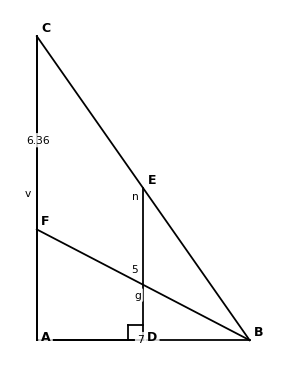

In [4]:
fig, ax = plt.subplots(figsize=(8,6),dpi = 64)
tri = Triangle(7,10)
tri.third_vertice("right")
tri.add_perpendicular("AB","C")
#tri.add_median("C","AB")
tri.add_bisector("ABC")
tri.set_question()
plot_geometry_improved(tri.description)

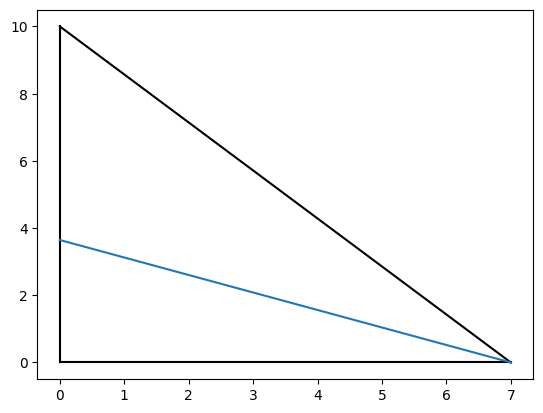

In [5]:
A,B,C = [np.array([tri.description["vertices"][i]["x"],tri.description["vertices"][i]["y"]]) for i in range(3)]
BC = C - B
BA = A - B
AC = C - A
BD_dir = BC/np.linalg.norm(BC)+BA/np.linalg.norm(BA)
BD_dir /= np.linalg.norm(BD_dir)
AC = AC/np.linalg.norm(AC)
plt.plot([A[0],B[0]],[A[1],B[1]],'k')
plt.plot([A[0],C[0]],[A[1],C[1]],'k')
plt.plot([C[0],B[0]],[C[1],B[1]],'k')
factor = (B[1]-A[1]+A[0]-B[0])/(BD_dir[0]*AC[1]-AC[0]*BD_dir[1])
plt.plot([B[0],(B+BD_dir*factor)[0]],[B[1],(B+BD_dir*factor)[1]])

In [6]:
B + 5*BD_dir

array([2.56510662, 2.3090519 ])